In [38]:
import polars as pl
import numpy as np
import pandas as pd
path = '2021-2023/{}.parquet'

# concat 2021-2023 into single dataframe
df = pl.concat([
    pl.scan_parquet(path.format(2021)),
    pl.scan_parquet(path.format(2022)),
    pl.scan_parquet(path.format(2023))
])

In [29]:
df = df.with_columns([
    (pl.col('ended_at') - pl.col('started_at')).dt.seconds().alias('durationseconds'),
    pl.col('started_at').dt.hour().alias('starthour'),
    pl.col('ended_at').dt.hour().alias('endhour'),
    pl.col('started_at').dt.month().alias('month'),
    pl.col('started_at').dt.year().alias('year'),
]).drop(['ride_id', 'start_station_id', 'end_station_id']).drop_nulls()

In [30]:
df_sample = df.collect().sample(n=100000)
df_sample = df_sample.to_pandas()

In [42]:
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder

# encode categorical variables
le = LabelEncoder()
ohe = OneHotEncoder(sparse=False)

ohecols = ['start_station_name', 'end_station_name']
lecols = ['rideable_type', 'member_casual', 'month', 'year', 'endhour', 'starthour', 'year', 'durationseconds']

def preprocess(df):
    df = df.copy()
    for col in ohecols:
        df[col] = le.fit_transform(df[col])
    for col in lecols:
        df[col] = le.fit_transform(df[col])
    return df


In [47]:
preprocess_df = preprocess(df_sample)
preprocess_df.drop(['started_at', 'ended_at'], axis=1, inplace=True)

In [49]:
from sklearn.model_selection import train_test_split

X = preprocess_df.drop('rideable_type', axis=1)
y = preprocess_df['rideable_type']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)


In [72]:
from sklearn.ensemble import RandomForestClassifier

rf = RandomForestClassifier(n_estimators=500, max_depth=8, random_state=1)
rf.fit(X_train, y_train)

RandomForestClassifier(max_depth=8, n_estimators=500, random_state=1)

In [74]:
from sklearn.metrics import accuracy_score

y_pred = rf.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print('Accuracy: ', accuracy)

Accuracy:  0.77745


[Text(0.4230769230769231, 0.875, 'year <= 0.5\ngini = 0.489\nsamples = 80000\nvalue = [53839, 9137, 17024]\nclass = electric_bike'),
 Text(0.15384615384615385, 0.625, 'month <= 4.5\ngini = 0.631\nsamples = 27549\nvalue = [13047, 8792, 5710]\nclass = electric_bike'),
 Text(0.07692307692307693, 0.375, 'gini = 0.0\nsamples = 7222\nvalue = [0, 7222, 0]\nclass = docked_bike'),
 Text(0.23076923076923078, 0.375, 'month <= 5.5\ngini = 0.503\nsamples = 20327\nvalue = [13047, 1570, 5710]\nclass = electric_bike'),
 Text(0.15384615384615385, 0.125, 'gini = 0.651\nsamples = 3304\nvalue = [815, 1395, 1094]\nclass = docked_bike'),
 Text(0.3076923076923077, 0.125, 'gini = 0.41\nsamples = 17023\nvalue = [12232, 175, 4616]\nclass = electric_bike'),
 Text(0.6923076923076923, 0.625, 'year <= 1.5\ngini = 0.349\nsamples = 52451\nvalue = [40792, 345, 11314]\nclass = electric_bike'),
 Text(0.5384615384615384, 0.375, 'month <= 3.5\ngini = 0.4\nsamples = 32183\nvalue = [23463, 281, 8439]\nclass = electric_bike'

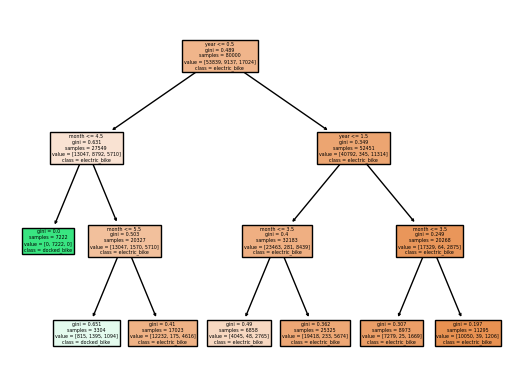

In [76]:
from sklearn.tree import DecisionTreeClassifier, plot_tree
clf = DecisionTreeClassifier(max_depth=3)
clf.fit(X_train, y_train)

plot_tree(clf, filled=True, feature_names=X.columns, class_names=['electric_bike', 'docked_bike', 'classic_bike'])